In [81]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle

In [28]:
%matplotlib inline
TIME_STEP = 64
IMG_SIZE = 32 

In [3]:
dataset = pd.read_csv('data_earthquake_2000-2017.csv',encoding='latin1', sep=';')
dataset.head()

,Año,Mes,Día,Hora,Minuto,Segundo,Fecha,Latitud,Longitud,Prof.,Magn,Date,Horario,Dtime,time,diff
0,2000,1,2,3,42,12.7,36527,-33.410,-70.880,81.9,2.5,36527,0.154314,36527.15431,1.154314,0.000000
1,2000,1,2,5,3,13.1,36527,-33.787,-71.339,45.8,3.7,36527,0.210568,36527.21057,1.210568,0.056255
2,2000,1,2,18,55,55.0,36527,-31.535,-71.318,35.7,3.8,36527,0.788831,36527.78883,1.788831,0.578263
3,2000,1,2,19,36,25.8,36527,-32.446,-70.923,95.2,2.7,36527,0.816965,36527.81697,1.816965,0.028134
4,2000,1,3,2,41,41.7,36528,-32.986,-71.348,41.8,3.6,36528,0.112288,36528.11229,2.112288,0.295323


In [25]:
print(dataset.shape)
dataset = dataset[dataset['Prof.'] >= 60.0 ]
print(dataset.shape)

(85636, 16)
(37195, 16)


In [4]:
zone1 = dataset[dataset['Latitud'] > -23]
zone2 = dataset[(dataset.Latitud < -23) & (dataset.Latitud > -34)] 
zone3 = dataset[dataset['Latitud'] < -34]
print(dataset.shape)
print(zone1.shape)


(85636, 16)
(23288, 16)


In [5]:
def scale(data):
    old_max = data['Magn'].max()
    old_min = data['Magn'].min()
    old_range =  old_max - old_min
    new_range = 255 - 10 
    return data['Magn'].apply(lambda v: int(((v-old_min)*new_range)/old_range)-10)
    
zone3['Magn']= scale(zone3)

/home/sergio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
def build_time_series(data,timestep,y_col=0):
    dim_0 = data.shape[0]-timestep
    first = data.Date[:1].values[0]
    y = []
    series = []
    for i in range(dim_0):
        series_df = data[(data.Date >= first+i) & (data.Date < first+i+timestep)]
        y_df = data[data.Date == first+i+timestep]
        series.append(series_df)
        y.append(y_df)

    return series,y,first

series,y,first = build_time_series(zone3,TIME_STEP)
series[0]

,Año,Mes,Día,Hora,Minuto,Segundo,Fecha,Latitud,Longitud,Prof.,Magn,Date,Horario,Dtime,time,diff
9,2000,1,4,11,47,18.2,36529,-34.944,-71.492,52.8,67,36529,0.491183,36529.49118,3.491183,0.114757
15,2000,1,5,9,26,58.9,36530,-34.442,-72.122,28.7,60,36530,0.393737,36530.39374,4.393737,0.051875
19,2000,1,5,20,57,16.9,36530,-34.616,-71.139,66.5,44,36530,0.873112,36530.87311,4.873112,0.168722
21,2000,1,6,1,48,8.7,36531,-34.643,-70.740,102.1,64,36531,0.075101,36531.07510,5.075101,0.181978
26,2000,1,7,1,48,55.4,36532,-34.220,-71.539,45.5,60,36532,0.075641,36532.07564,6.075641,0.028185
27,2000,1,7,2,51,2.2,36532,-34.863,-71.068,102.1,35,36532,0.118775,36532.11878,6.118775,0.043134
43,2000,1,10,9,13,6.9,36535,-36.737,-72.596,16.8,80,36535,0.384108,36535.38411,9.384108,0.033244
44,2000,1,10,11,43,22.3,36535,-34.608,-71.773,33.0,86,36535,0.488453,36535.48845,9.488453,0.104345
48,2000,1,11,9,8,53.5,36536,-34.578,-72.521,4.7,67,36536,0.381175,36536.38117,10.381175,0.072781
50,2000,1,12,4,11,3.8,36537,-34.083,-70.093,8.9,64,36537,0.174350,36537.17435,11.174350,0.621229


In [69]:
def create_matrix(data,n_size,timestep,current_date):
    max_lat = data['Latitud'].max()
    min_lat = data['Latitud'].min()
    max_lon = data['Longitud'].max()
    min_lon = data['Longitud'].min()
    n_rows = n_columns = n_size
    matrix = np.zeros(shape=(n_rows,n_columns),dtype=int)
    n_sum_lat = (max_lat-min_lat)/n_columns
    n_sum_lon = (max_lon-min_lon)/n_rows

    X = []
    for k in range (timestep):
        dayk = data.loc[(data['Date'] == current_date+k)]
        start_lon = min_lon
        end_lon = min_lon + n_sum_lon
        for i in range (n_rows):
            start_lat = min_lat
            end_lat = min_lat + n_sum_lat
            for j in range (n_columns):
                x = dayk.loc[(dayk['Latitud'] >= start_lat) & (dayk['Latitud'] <= end_lat) & (dayk['Longitud'] >= start_lon) & (dayk['Longitud'] <= end_lon)]
                ##print(x.Magn.values,end = '')
                matrix[i][j] = x['Magn'].max() if (len(x['Magn'].values) != 0) else 0
                #print(matrix[i][j],end = '')
                start_lat = end_lat
                end_lat = end_lat + n_sum_lat
            #print('')
            start_lon = end_lon
            end_lon = end_lon + n_sum_lon
        #print('*****************************************************************')
        #X.append(matrix.flatten())
        img = Image.fromarray(matrix.astype('uint8'),'L')
        X.append(img)
    return X

In [70]:
X = []
for num, serie in enumerate(series):
    X.append(create_matrix(serie,IMG_SIZE,TIME_STEP,first+num))
pickle_X_out = open("X.pickle","wb")
pickle.dump(X,pickle_X_out)
pickle_X_out.close()

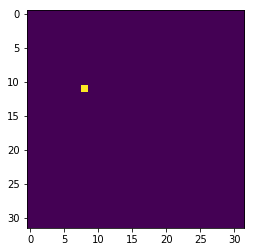

In [78]:
aux = [X]
plt.imshow(np.asarray(aux[0][19]))

In [79]:
def create_images_input(X):
    

    for it, images in enumerate(X):
        
        widths, heights = zip(*(i.size for i in images))
        total_width = sum(widths)
        max_height = max(heights)
        
        new_im = Image.new('L', (total_width, max_height))
        
        x_offset = 0
        #print(len(images))
        
        for im in images:
            plt.imshow(np.asarray(im))
            new_im.paste(im, (x_offset,0))
            x_offset += im.size[0]
   
        #imshow(np.asarray(new_im))
        new_im.save("images/quake3-{0}.jpg".format(it), "JPEG", quality=80, optimize=True, progressive=True)
            

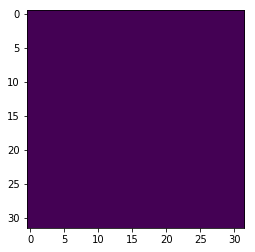

In [80]:
create_images_input(aux)